In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from json_data_getter import get_all_json

## Data loading

In [2]:
# gets all the json files toghether, may take a minute
number_documents, keys, documents = get_all_json()

In [3]:
df = pd.DataFrame.from_dict(documents)
df.columns

Index(['alternativeExcerpt', 'alternativeTitle', 'articleURL', 'backgrounds',
       'contributors', 'durationSec', 'excerpt', 'genres', 'id', 'imageURL',
       'isOnline', 'mediaType', 'mediaURL', 'program',
       'publicationChannelNames', 'publicationDate', 'source',
       'thematicCorporations', 'thematicGeographicals', 'thematicPersons',
       'thematicThemes', 'title', 'variantIds', 'visualCorporations',
       'visualGeographicals', 'visualPersons', 'visualThemes'],
      dtype='object')

In [4]:
df['publicationDate'] =  pd.to_datetime(df['publicationDate'], format='%Y-%m-%dT%H:%M:%SZ')

## distribution in time

In [284]:
doc_per_year = df.groupby(df.publicationDate.map(lambda x: x.year)).size()

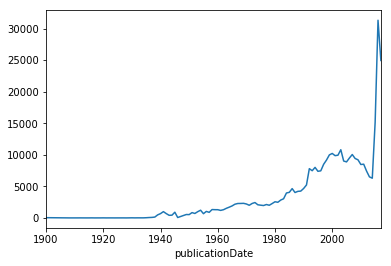

In [6]:
doc_per_year.plot(logy=0)
plt.show()

## Programs duration

In [387]:
def get_show_duration(df):
    program_groups = df.groupby(df.program)
    df_duration = program_groups.publicationDate.agg(['min', 'max', 'size'])
    df_duration['duration_days'] = (df_duration['max'] - df_duration['min']).astype('timedelta64[D]')
    return df_duration

In [388]:
get_show_duration(df).sort_values('duration_days', ascending=False).head()

,min,max,size,duration_days
program,,,,
TJ midi,1900-01-01 19:00:00,2011-12-04 11:45:00,204,40878.0
Marabout de ficelle,1900-01-01 00:00:00,1998-05-20 00:00:00,148,35933.0
Mémoires de la musique,1922-06-05 00:00:00,2004-01-23 00:00:00,2086,29817.0
Archives,1939-11-30 02:00:00,2017-10-03 13:10:37,120,28432.0
Horloge de sable,1939-01-01 00:00:00,2016-07-02 00:00:00,666,28307.0


Some duration seem a bit too long, maybe there are errors in the dates.

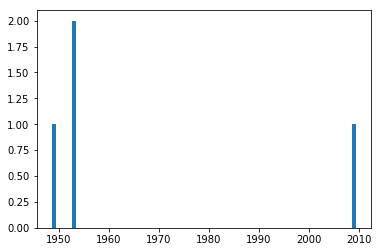

In [405]:
program_groups = df.groupby(df.program)

TJmidi = program_groups.get_group('TJ midi')

TJmidi_date_distribution = TJmidi.groupby(TJmidi.publicationDate.map(lambda x: (x.year))).size()

plt.bar(TJmidi_date_distribution.index,TJmidi_date_distribution.values)

plt.show()

In [402]:
# remove outliers
def remove_date_outliers(df):
    df['publicationDateYear'] = df.publicationDate.map(lambda x: x.year)
    mean_std_year_per_program = df.groupby(df.program).publicationDateYear.agg(["mean",'std'])
    temp_df = pd.merge(df, mean_std_year_per_program, how='left', left_on=['program'], right_index=True)
    df_without_date_outliers = temp_df[(np.abs(temp_df.publicationDateYear - temp_df['mean']) < 2*temp_df['std'])]
    return df_without_date_outliers

In [447]:
df_without_date_outliers = remove_date_outliers(df)
get_show_duration(df_without_date_outliers).sort_values('size', ascending=False).head()

,min,max,size,duration_days
program,,,,
Journal du matin,1989-01-07 00:00:00,2017-08-28 00:00:00,21410,10460.0
Télé journal,1982-01-01 00:00:00,1996-09-30 23:00:00,10436,5386.0
Forum,2004-12-26 23:00:00,2017-11-02 00:00:00,9187,4693.0
Journal de midi,1982-01-09 00:00:00,2017-08-01 00:00:00,8077,12988.0
Le journal,2006-01-09 00:00:00,2013-12-04 00:00:00,7661,2886.0


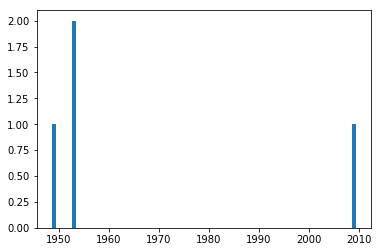

In [404]:
program_groups_without_outliers = df_without_date_outliers.groupby(df.program)

TJmidi = program_groups_without_outliers.get_group('TJ midi')

TJmidi_date_distribution = TJmidi.groupby(TJmidi.publicationDate.map(lambda x: (x.year))).size()

plt.bar(TJmidi_date_distribution.index, TJmidi_date_distribution.values)

plt.show()

## Genres

In [545]:
for t,d in df[[not x for x in df.genres.isnull()]].groupby('program'):
    print(d)
    break

       alternativeExcerpt alternativeTitle articleURL backgrounds  \
166752                NaN              NaN        NaN         NaN   
167149                NaN              NaN        NaN         NaN   
167194                NaN              NaN        NaN         NaN   
167362                NaN              NaN        NaN         NaN   
167395                NaN              NaN        NaN         NaN   
167413                NaN              NaN        NaN         NaN   
167461                NaN              NaN        NaN         NaN   
167484                NaN              NaN        NaN         NaN   
167579                NaN              NaN        NaN         NaN   
167604                NaN              NaN        NaN         NaN   
167635                NaN              NaN        NaN         NaN   
167644                NaN              NaN        NaN         NaN   
167678                NaN              NaN        NaN         NaN   
167704                NaN         

In [525]:
program_groups_without_outliers.apply(lambda x : x.genres.sum(skipna=True))

TypeError: can only concatenate list (not "int") to list